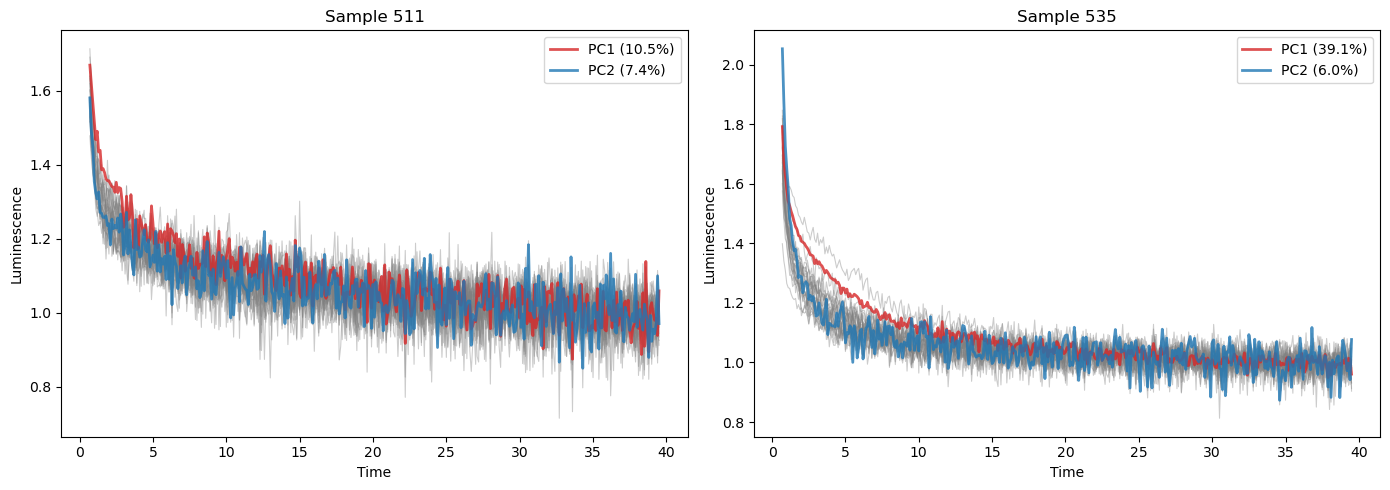

In [1]:
import os, pickle, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ------------------------------------------------------------------
# Load data
# ------------------------------------------------------------------
pickle_path = 'output/processed_data.pkl'
if not os.path.exists(pickle_path):
    raise FileNotFoundError("Pickle file not found. Please check the path.")

with open(pickle_path, 'rb') as f:
    data_dict = pickle.load(f)

# Helper to prepare matrix for a given sample key
def sample_matrix(sample_key):
    df = data_dict[sample_key]
    time = df['Time'].astype(float).values
    slice_cols = df.columns.difference(['Time_index', 'Time'])
    # (n_time, n_slices) -> transpose to (n_slices, n_time)
    X = df[slice_cols].to_numpy(dtype=float).T
    return time, X, slice_cols

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, sample in zip(axes, ['511', '535']):
    time, Xs, cols = sample_matrix(sample)
    
    # center data (features=time bins)
    X_center = Xs - Xs.mean(axis=0, keepdims=True)
    
    pca = PCA(n_components=2)
    pca.fit(X_center)
    pcs = pca.components_           # (2, n_time)
    
    # scale PCs for visibility: add mean and scale to max amplitude of mean curve
    mean_curve = Xs.mean(axis=0)
    pc_lines = []
    for comp in pcs:
        scale = np.max(np.abs(comp))
        pc_lines.append(mean_curve + comp)
    
    # Plot all slices
    ax.plot(time, Xs.T, color='grey', alpha=0.4, lw=0.8, label='_nolegend_')
    # plot first two PCs
    colors = ['tab:red', 'tab:blue']
    labels = [f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)',
              f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)']
    for line, col, lab in zip(pc_lines, colors, labels):
        ax.plot(time, line, color=col, lw=2, label=lab, alpha=0.8)
    
    ax.set_title(f'Sample {sample}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Luminescence')
    ax.legend()

fig.tight_layout()
plt.show()


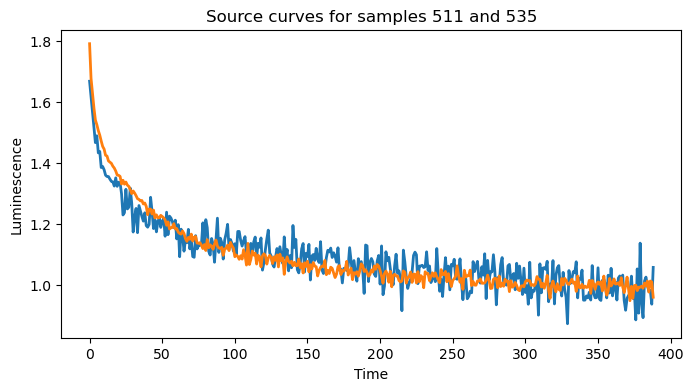

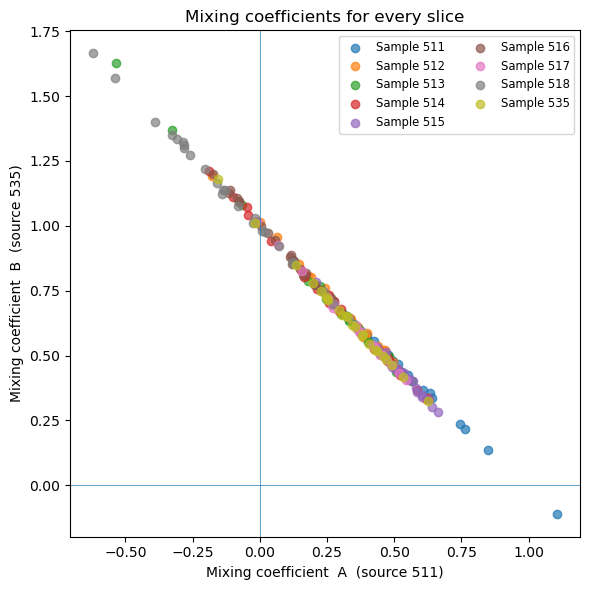

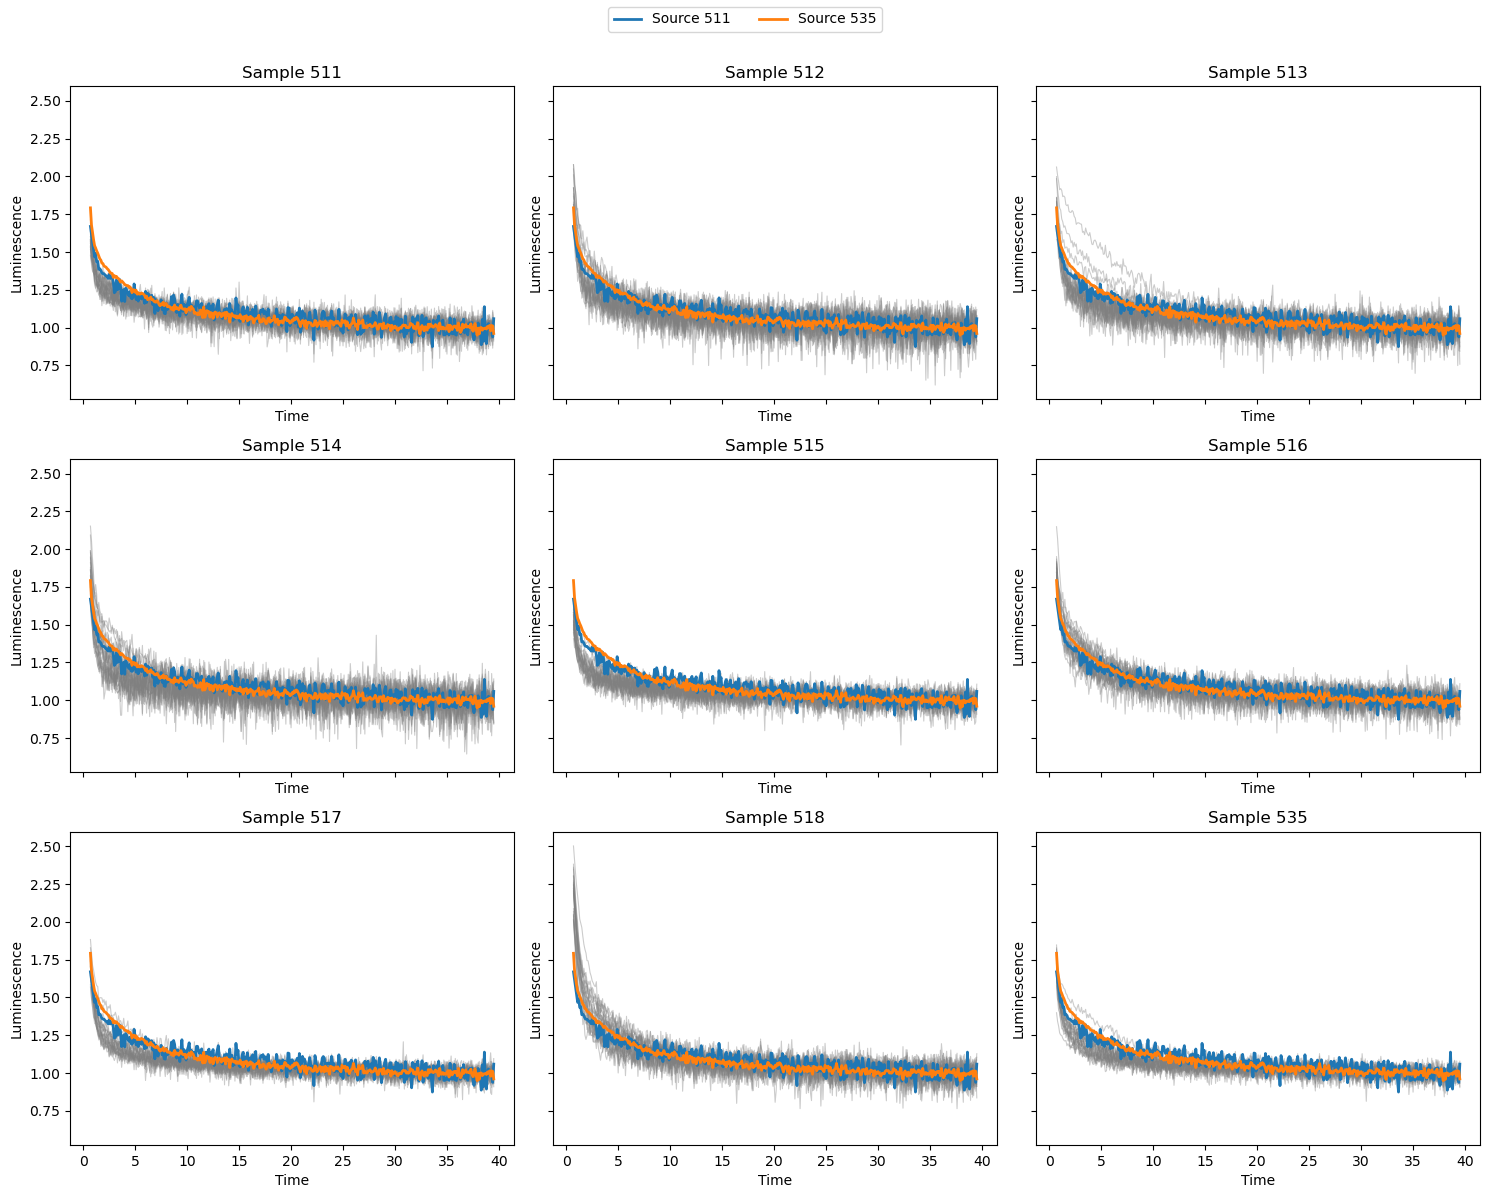

In [2]:
import os, pickle, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# -------------------- Load data --------------------
pickle_path = 'output/processed_data.pkl'
if not os.path.exists(pickle_path):
    raise FileNotFoundError("Pickle file not found at 'output/processed_data.pkl'.")

with open(pickle_path, 'rb') as f:
    data_dict = pickle.load(f)

# -------------------- Helper --------------------
def sample_matrix(sample_key):
    """Return (time, X, slice_names) for a sample.
       X shape: (n_slices, n_time)"""
    df = data_dict[sample_key]
    time = df['Time'].astype(float).values
    slice_cols = df.columns.difference(['Time_index', 'Time'])
    X = df[slice_cols].to_numpy(dtype=float).T
    return time, X, slice_cols

# -------------------- Derive the two source curves --------------------
sources = {}
for sample_key in ['511', '535']:
    time, Xs, _ = sample_matrix(sample_key)
    X_center = Xs - Xs.mean(axis=0, keepdims=True)
    pca = PCA(n_components=1).fit(X_center)
    comp = pca.components_[0]           # (n_time,)
    mean_curve = Xs.mean(axis=0)
    # Following user's earlier approach: source = mean_curve + comp
    sources[sample_key] = mean_curve + comp

source1 = sources['511']
source2 = sources['535']




# # 直接使用511和535的平均值作为物源
# df_temp=data_dict['511']
# slice_cols = df_temp.columns.difference(['Time_index', 'Time'])
# # calculate the mean of all columns
# # mean_values = df_temp[slice_cols].mean(axis=1)
# # use median
# mean_values = df_temp[slice_cols].median(axis=1)
# source1 = mean_values


# df_temp=data_dict['535']
# slice_cols = df_temp.columns.difference(['Time_index', 'Time'])
# # calculate the mean of all columns
# # mean_values = df_temp[slice_cols].mean(axis=1)

# # use median
# mean_values = df_temp[slice_cols].median(axis=1)
# source2 = mean_values





# plot the two sources
plt.figure(figsize=(8, 4))
plt.plot(source1, lw=2, label='Source 511')
plt.plot(source2, lw=2, label='Source 535')
plt.xlabel('Time')
plt.ylabel('Luminescence')
plt.title('Source curves for samples 511 and 535')

# Stack sources into design matrix S of shape (n_time, 2)
S = np.vstack([source1, source2]).T

# Pre-compute pseudo-inverse once for speed
pinv = np.linalg.pinv(S)

# -------------------- Solve A, B for every slice --------------------
results = []   # list of dicts: sample, slice_name, A, B
for sample_key in sorted(data_dict.keys()):
    time, Xs, slice_cols = sample_matrix(sample_key)
    for idx, slice_name in enumerate(slice_cols):
        y = Xs[idx]            # (n_time,)
        A, B = pinv @ y
        results.append({'sample': sample_key, 'slice': slice_name, 'A': A, 'B': B})

results_df = pd.DataFrame(results)

# -------------------- Scatter plot of A vs B --------------------
plt.figure(figsize=(6, 6))
for sample_key, grp in results_df.groupby('sample'):
    plt.scatter(grp['A'], grp['B'], label=f'Sample {sample_key}', alpha=0.7)
plt.axhline(0, lw=0.5); plt.axvline(0, lw=0.5)
plt.xlabel('Mixing coefficient  A  (source 511)')
plt.ylabel('Mixing coefficient  B  (source 535)')
plt.title('Mixing coefficients for every slice')
plt.legend(fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

samples = sorted(data_dict.keys())          # 9 keys → row-major order
n_rows, n_cols = 3, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12), sharex=True, sharey=True)

for ax, sample_key in zip(axes.ravel(), samples):
    time, Xs, _ = sample_matrix(sample_key)

    # plot every slice for this sample in grey
    ax.plot(time, Xs.T, color='grey', alpha=0.4, lw=0.8)

    # overlay the two sources
    ax.plot(time, source1, lw=2, label='Source 511')
    ax.plot(time, source2, lw=2, label='Source 535')

    # cosmetics
    ax.set_title(f'Sample {sample_key}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Luminescence')

# One shared legend (outside the grid)
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2)

fig.tight_layout(rect=[0, 0, 1, 0.96])     # leave room for the legend
plt.show()

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Pre-compute pseudo-inverse once (sources stacked column-wise)
# ------------------------------------------------------------------
S      = np.vstack([source1, source2]).T        # shape (n_time, 2)
S_pinv = np.linalg.pinv(S)                      # shape (2, n_time)

def plot_sample_fits(sample_key, n_cols=4):
    """
    Visual-diagnostic plot of every slice in a sample vs its two-source fit.

    Parameters
    ----------
    sample_key : str
        The key in `data_dict` (e.g. '511').
    n_cols : int, optional
        Number of subplot columns (rows are computed automatically).
    """
    # ---------- pull data ----------
    time, Xs, slice_names = sample_matrix(sample_key)   # Xs: (n_slices, n_time)
    n_slices  = Xs.shape[0]
    n_rows    = int(np.ceil(n_slices / n_cols))

    # ---------- set up figure ----------
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4*n_cols, 3*n_rows),
                             sharex=True, sharey=True)
    axes = axes.ravel()       # flatten for easy indexing

    # ---------- iterate over slices ----------
    for i in range(n_slices):
        ax   = axes[i]
        y    = Xs[i]

        # optimal (A, B) by least squares
        A, B = S_pinv @ y
        yhat = A*source1 + B*source2
        rmse = np.sqrt(np.mean((y - yhat)**2))
        # normalize the rmse to the mean of the slice
        rmse /= np.mean(y) if np.mean(y) != 0 else 1e-10

        # plot
        ax.plot(time, y,           lw=1,  color='grey', label='slice')
        ax.plot(time, yhat,        lw=1.6, linestyle='-', color='r', label='fit')
        ax.set_title(f'{slice_names[i]}\nA={A:.2f}, B={B:.2f}, RMSE={rmse:.3g}',
                     fontsize=9)

    # remove empty axes (if slice count isn’t a multiple of n_cols)
    for j in range(n_slices, n_rows*n_cols):
        fig.delaxes(axes[j])

    # one common legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2)
    # fig.suptitle(f'Sample {sample_key}: slice vs. two-source fit', y=0.99)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


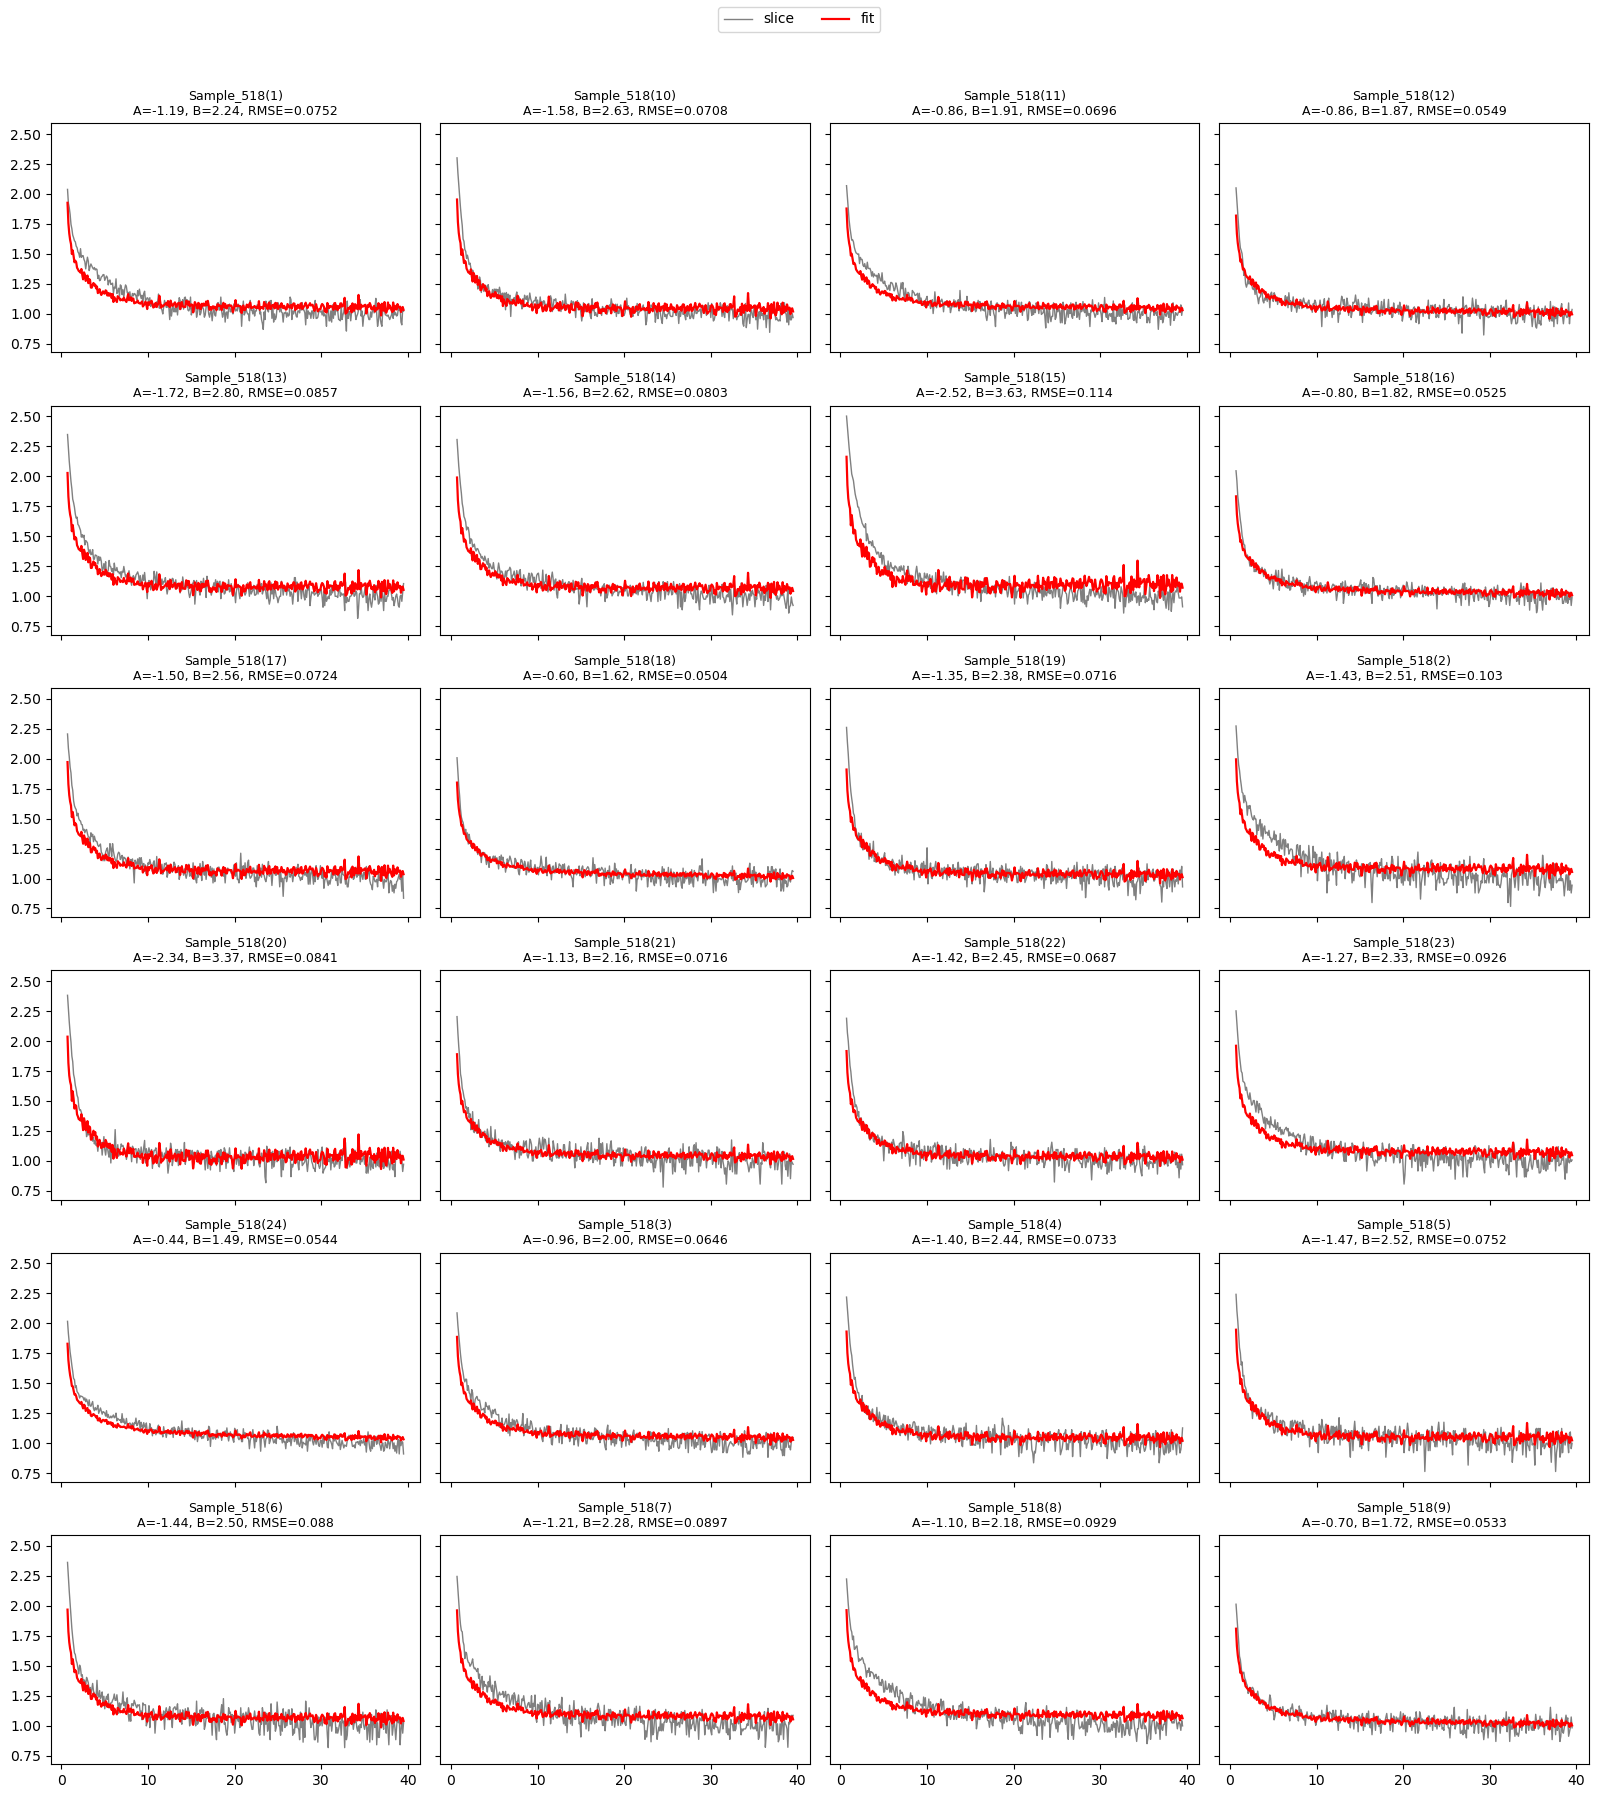

In [133]:
plot_sample_fits('518')    # or any of the 9 sample keys


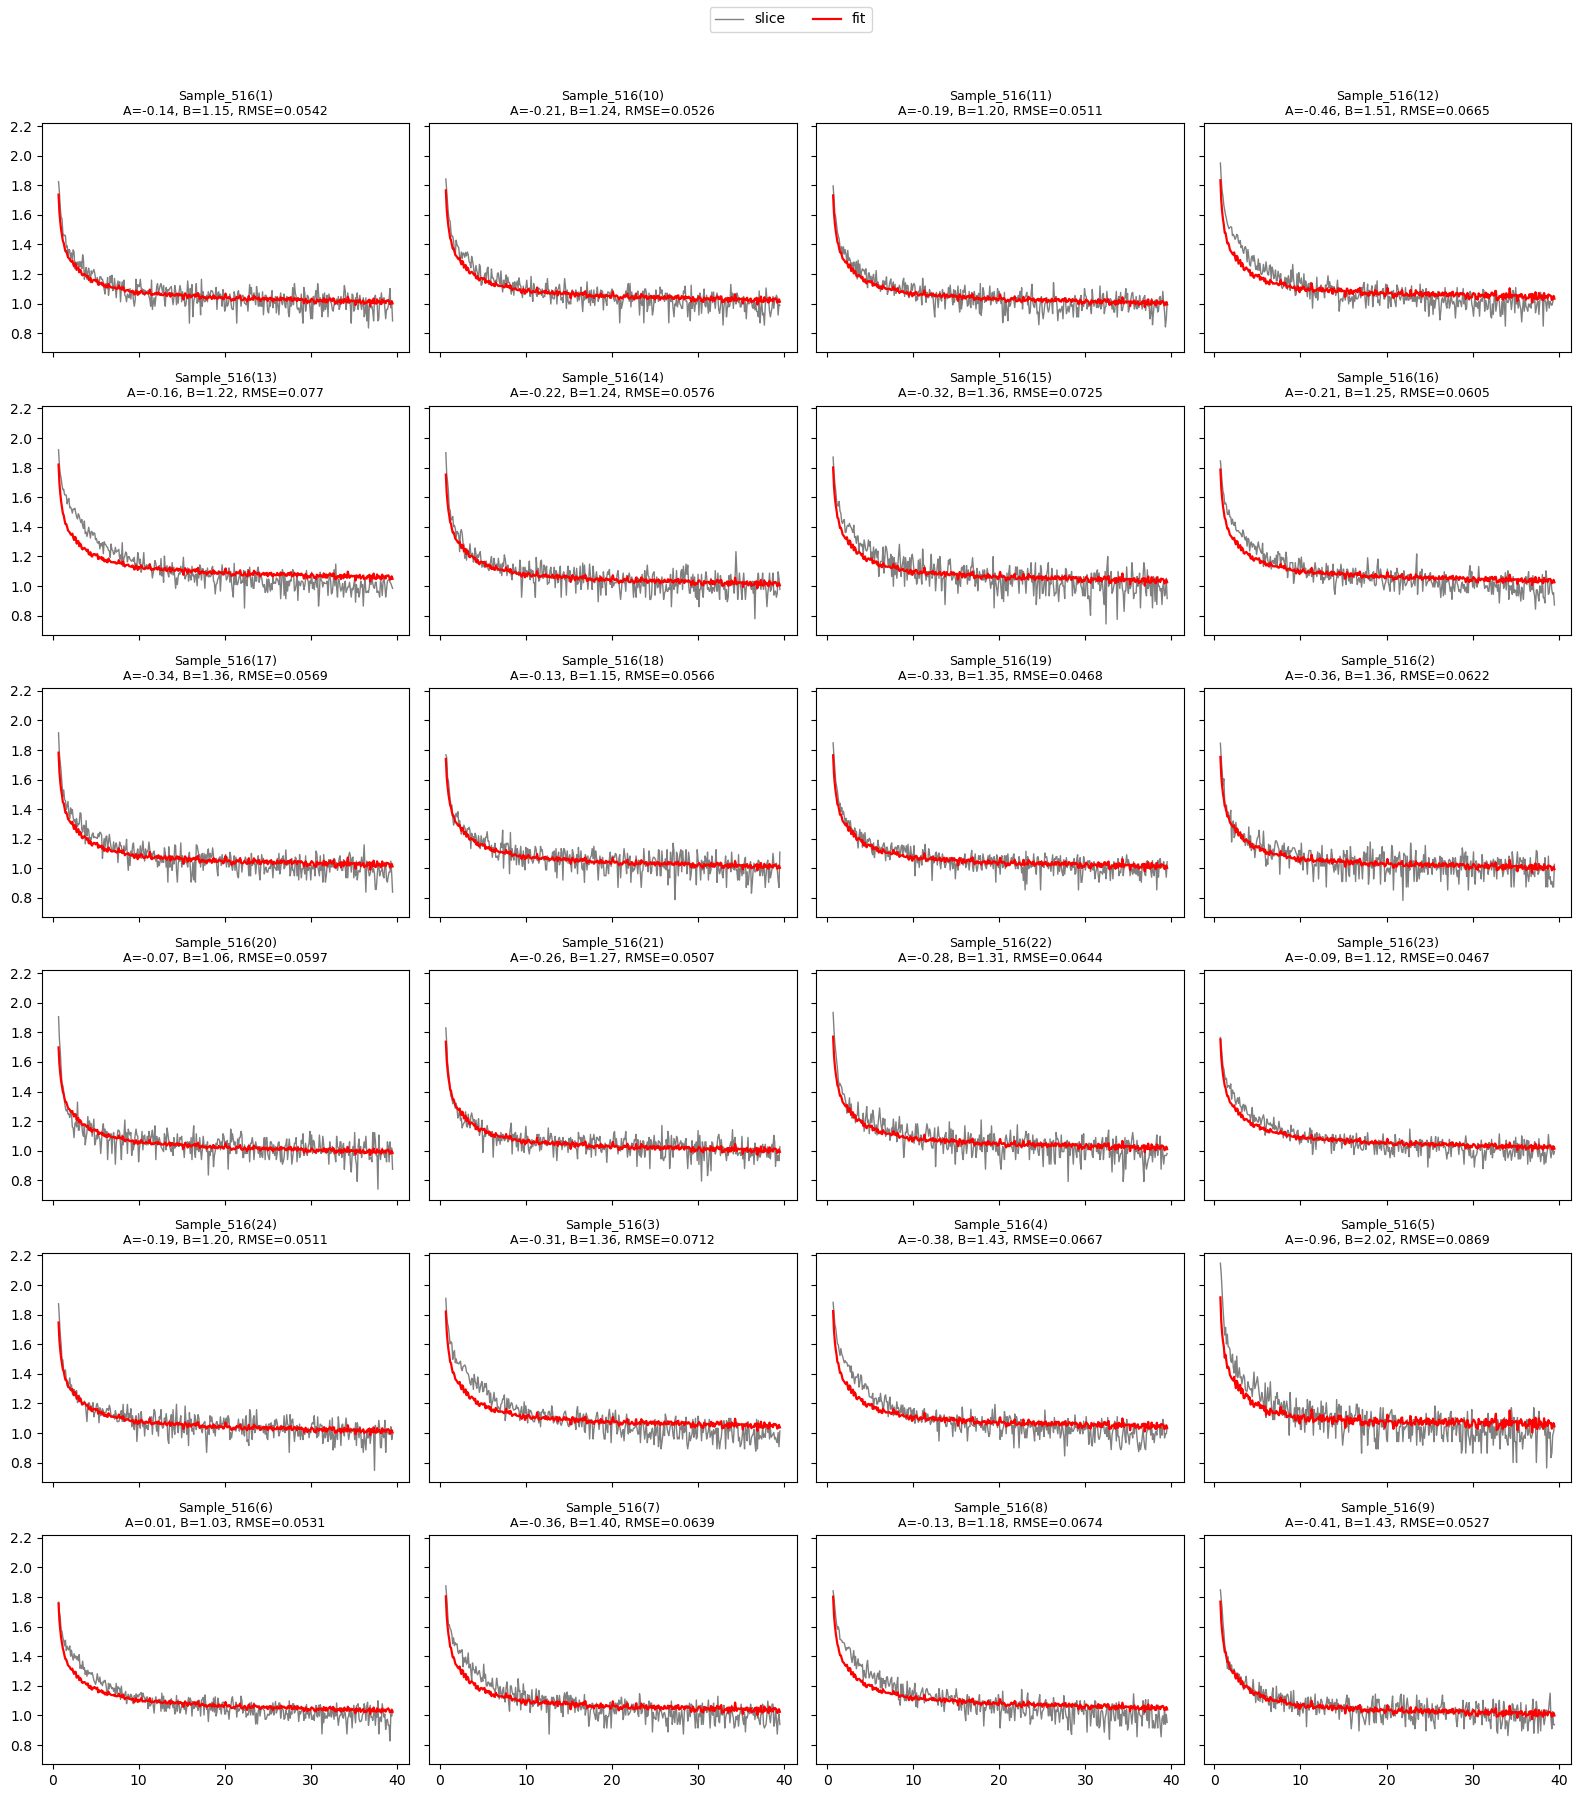

In [82]:
plot_sample_fits('516')    # or any of the 9 sample keys

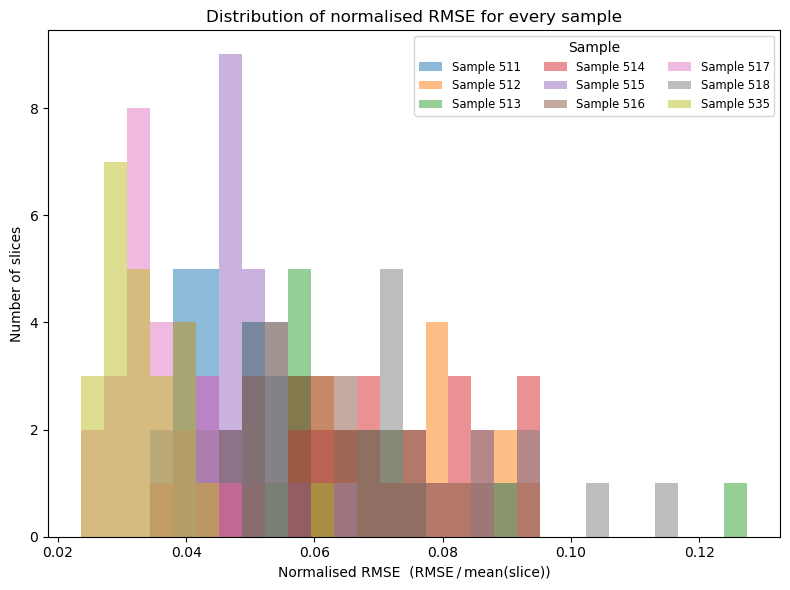

In [117]:
# ------------------------------------------------------------------
# Normalised‑RMSE histograms for all samples
# ------------------------------------------------------------------
cmap            = plt.colormaps['tab10']           # 10 qualitative colours
norm_rmse_dict  = {}                               # {sample: 1‑D array}

for i, sample_key in enumerate(sorted(data_dict.keys())):
    time, Xs, _ = sample_matrix(sample_key)        # (n_slices, n_time)
    rmse_list   = []

    for y in Xs:
        A, B  = S_pinv @ y
        yhat  = A*source1 + B*source2
        rmse  = np.sqrt(np.mean((y - yhat)**2))
        rmse /= np.mean(y) if np.mean(y) != 0 else 1e-10   # normalise
        rmse_list.append(rmse)

    norm_rmse_dict[sample_key] = np.asarray(rmse_list)

# ------- common binning so the histograms align -------------------
all_vals = np.concatenate(list(norm_rmse_dict.values()))
bins     = np.linspace(all_vals.min(), all_vals.max(), 30)

# ------- plot ------------------------------------------------------
plt.figure(figsize=(8, 6))
for i, (sample_key, vals) in enumerate(norm_rmse_dict.items()):
    plt.hist(vals, bins=bins, alpha=0.5, density=False,
             color=cmap(i % 10), label=f'Sample {sample_key}')

plt.xlabel('Normalised RMSE  (RMSE / mean(slice))')
plt.ylabel('Number of slices')
plt.title('Distribution of normalised RMSE for every sample')
plt.legend(title='Sample', fontsize='small', ncol=3)
plt.tight_layout()
plt.show()


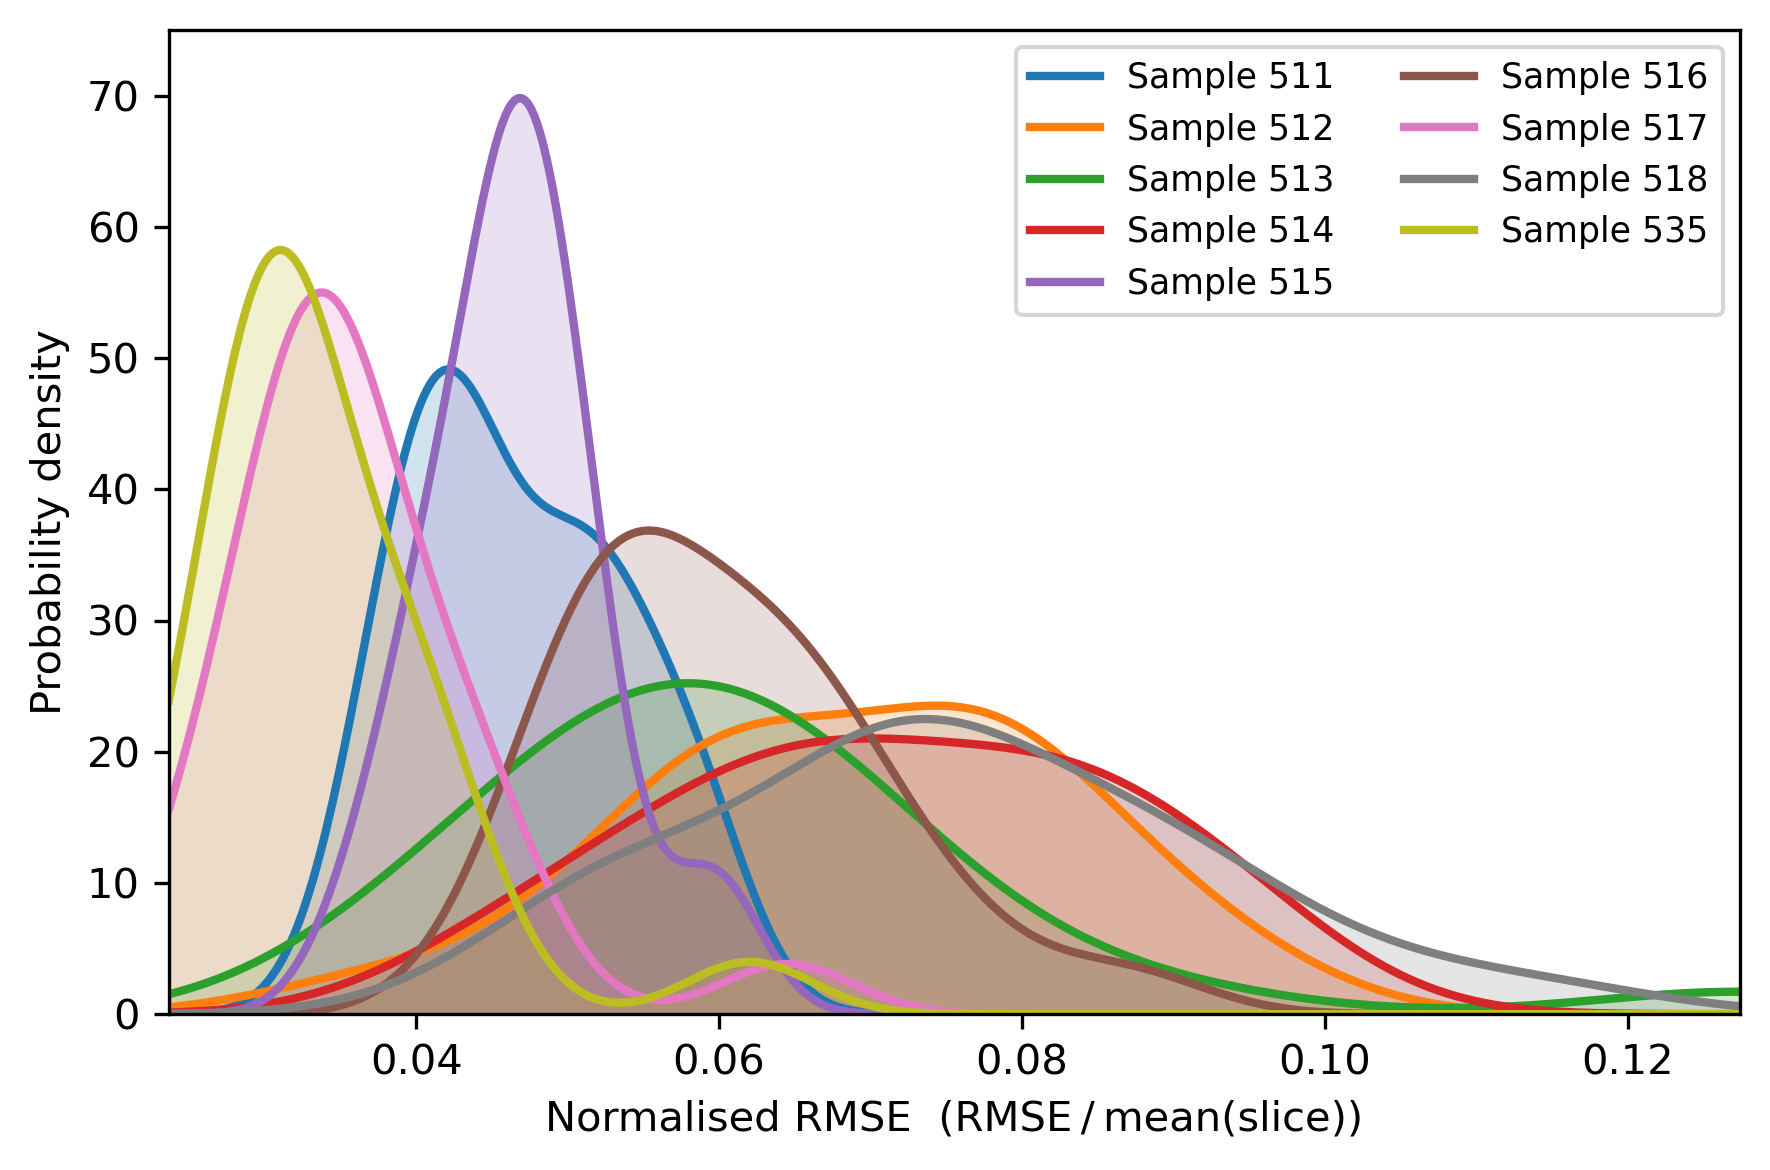

In [129]:
# --------------------------------------------------------------
# Plot KDE “fits” to the per‑sample RMSE distributions
# --------------------------------------------------------------
from scipy.stats import gaussian_kde        # <-- new import


cmap            = plt.colormaps['tab10']           # 10 qualitative colours
norm_rmse_dict  = {}                               # {sample: 1‑D array}

for i, sample_key in enumerate(sorted(data_dict.keys())):
    time, Xs, _ = sample_matrix(sample_key)        # (n_slices, n_time)
    rmse_list   = []

    for y in Xs:
        A, B  = S_pinv @ y
        yhat  = A*source1 + B*source2
        rmse  = np.sqrt(np.mean((y - yhat)**2))
        rmse /= np.mean(y) if np.mean(y) != 0 else 1e-10   # normalise
        rmse_list.append(rmse)

    norm_rmse_dict[sample_key] = np.asarray(rmse_list)

# ------- common binning so the histograms align -------------------
all_vals = np.concatenate(list(norm_rmse_dict.values()))
bins     = np.linspace(all_vals.min(), all_vals.max(), 30)

plt.figure(figsize=(6, 4),dpi=300)

# x‑grid common to all curves
x_grid = np.linspace(all_vals.min(), all_vals.max(), 500)

for i, (sample_key, vals) in enumerate(norm_rmse_dict.items()):
    kde  = gaussian_kde(vals, bw_method='scott')   # Scott’s rule bandwidth
    pdf  = kde(x_grid)                             # evaluate on grid
    

    plt.plot(x_grid, pdf,
             lw=2, color=cmap(i % 10),
             label=f'Sample {sample_key}')
    plt.fill_between(x_grid, 0, pdf,
                     color=cmap(i % 10), alpha=0.20)   # optional shading
    
# set x lim to the min/max of all samples
plt.xlim(all_vals.min(), all_vals.max())
plt.ylim(0, 75)         # y lim to the max of all samples

plt.xlabel('Normalised RMSE  (RMSE / mean(slice))')
plt.ylabel('Probability density')
# plt.title('Kernel‑density fit of normalised RMSE for every sample')
plt.legend(fontsize='small', ncol=2)
plt.tight_layout()
plt.show()


In [131]:
import numpy as np
import matplotlib.pyplot as plt

def plot_AB_across_slices(results_df, n_cols=3):
    """
    3×3 (or smaller) grid: A and B vs. slice index for every sample,
    with horizontal lines showing per-sample means.
    """
    samples   = sorted(results_df['sample'].unique())
    n_samples = len(samples)
    n_rows    = int(np.ceil(n_samples / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(5*n_cols, 3.5*n_rows),
                             sharey=True, dpi=300)

    axes_flat = np.ravel(axes)

    for idx, (ax, sample_key) in enumerate(zip(axes_flat, samples)):
        grp = results_df.loc[results_df['sample'] == sample_key].reset_index(drop=True)
        x   = np.arange(len(grp))

        # scatter/line for individual slices
        ax.plot(x, grp['A'], marker='o', lw=1.5, label='A (source 511)')
        ax.plot(x, grp['B'], marker='o', lw=1.5, label='B (source 535)')

        # per-sample means
        mean_A = grp['A'].mean()
        mean_B = grp['B'].mean()
        ax.axhline(mean_A, ls='--', lw=1, color='tab:blue')
        ax.axhline(mean_B, ls='--', lw=1, color='tab:red')

        ax.axhline(0, color='k', lw=0.5)
        ax.set_xlabel('Slice index')
        if idx % n_cols == 0:
            ax.set_ylabel('Mixing coefficient')

        ax.set_title(f'Sample {sample_key}\n⟨A⟩={mean_A:.2f}, ⟨B⟩={mean_B:.2f}',
                     fontsize=10)

    # hide unused panels
    for extra_ax in axes_flat[n_samples:]:
        extra_ax.set_visible(False)

    # single legend (first axis has the handles)
    handles, labels = axes_flat[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2)

    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


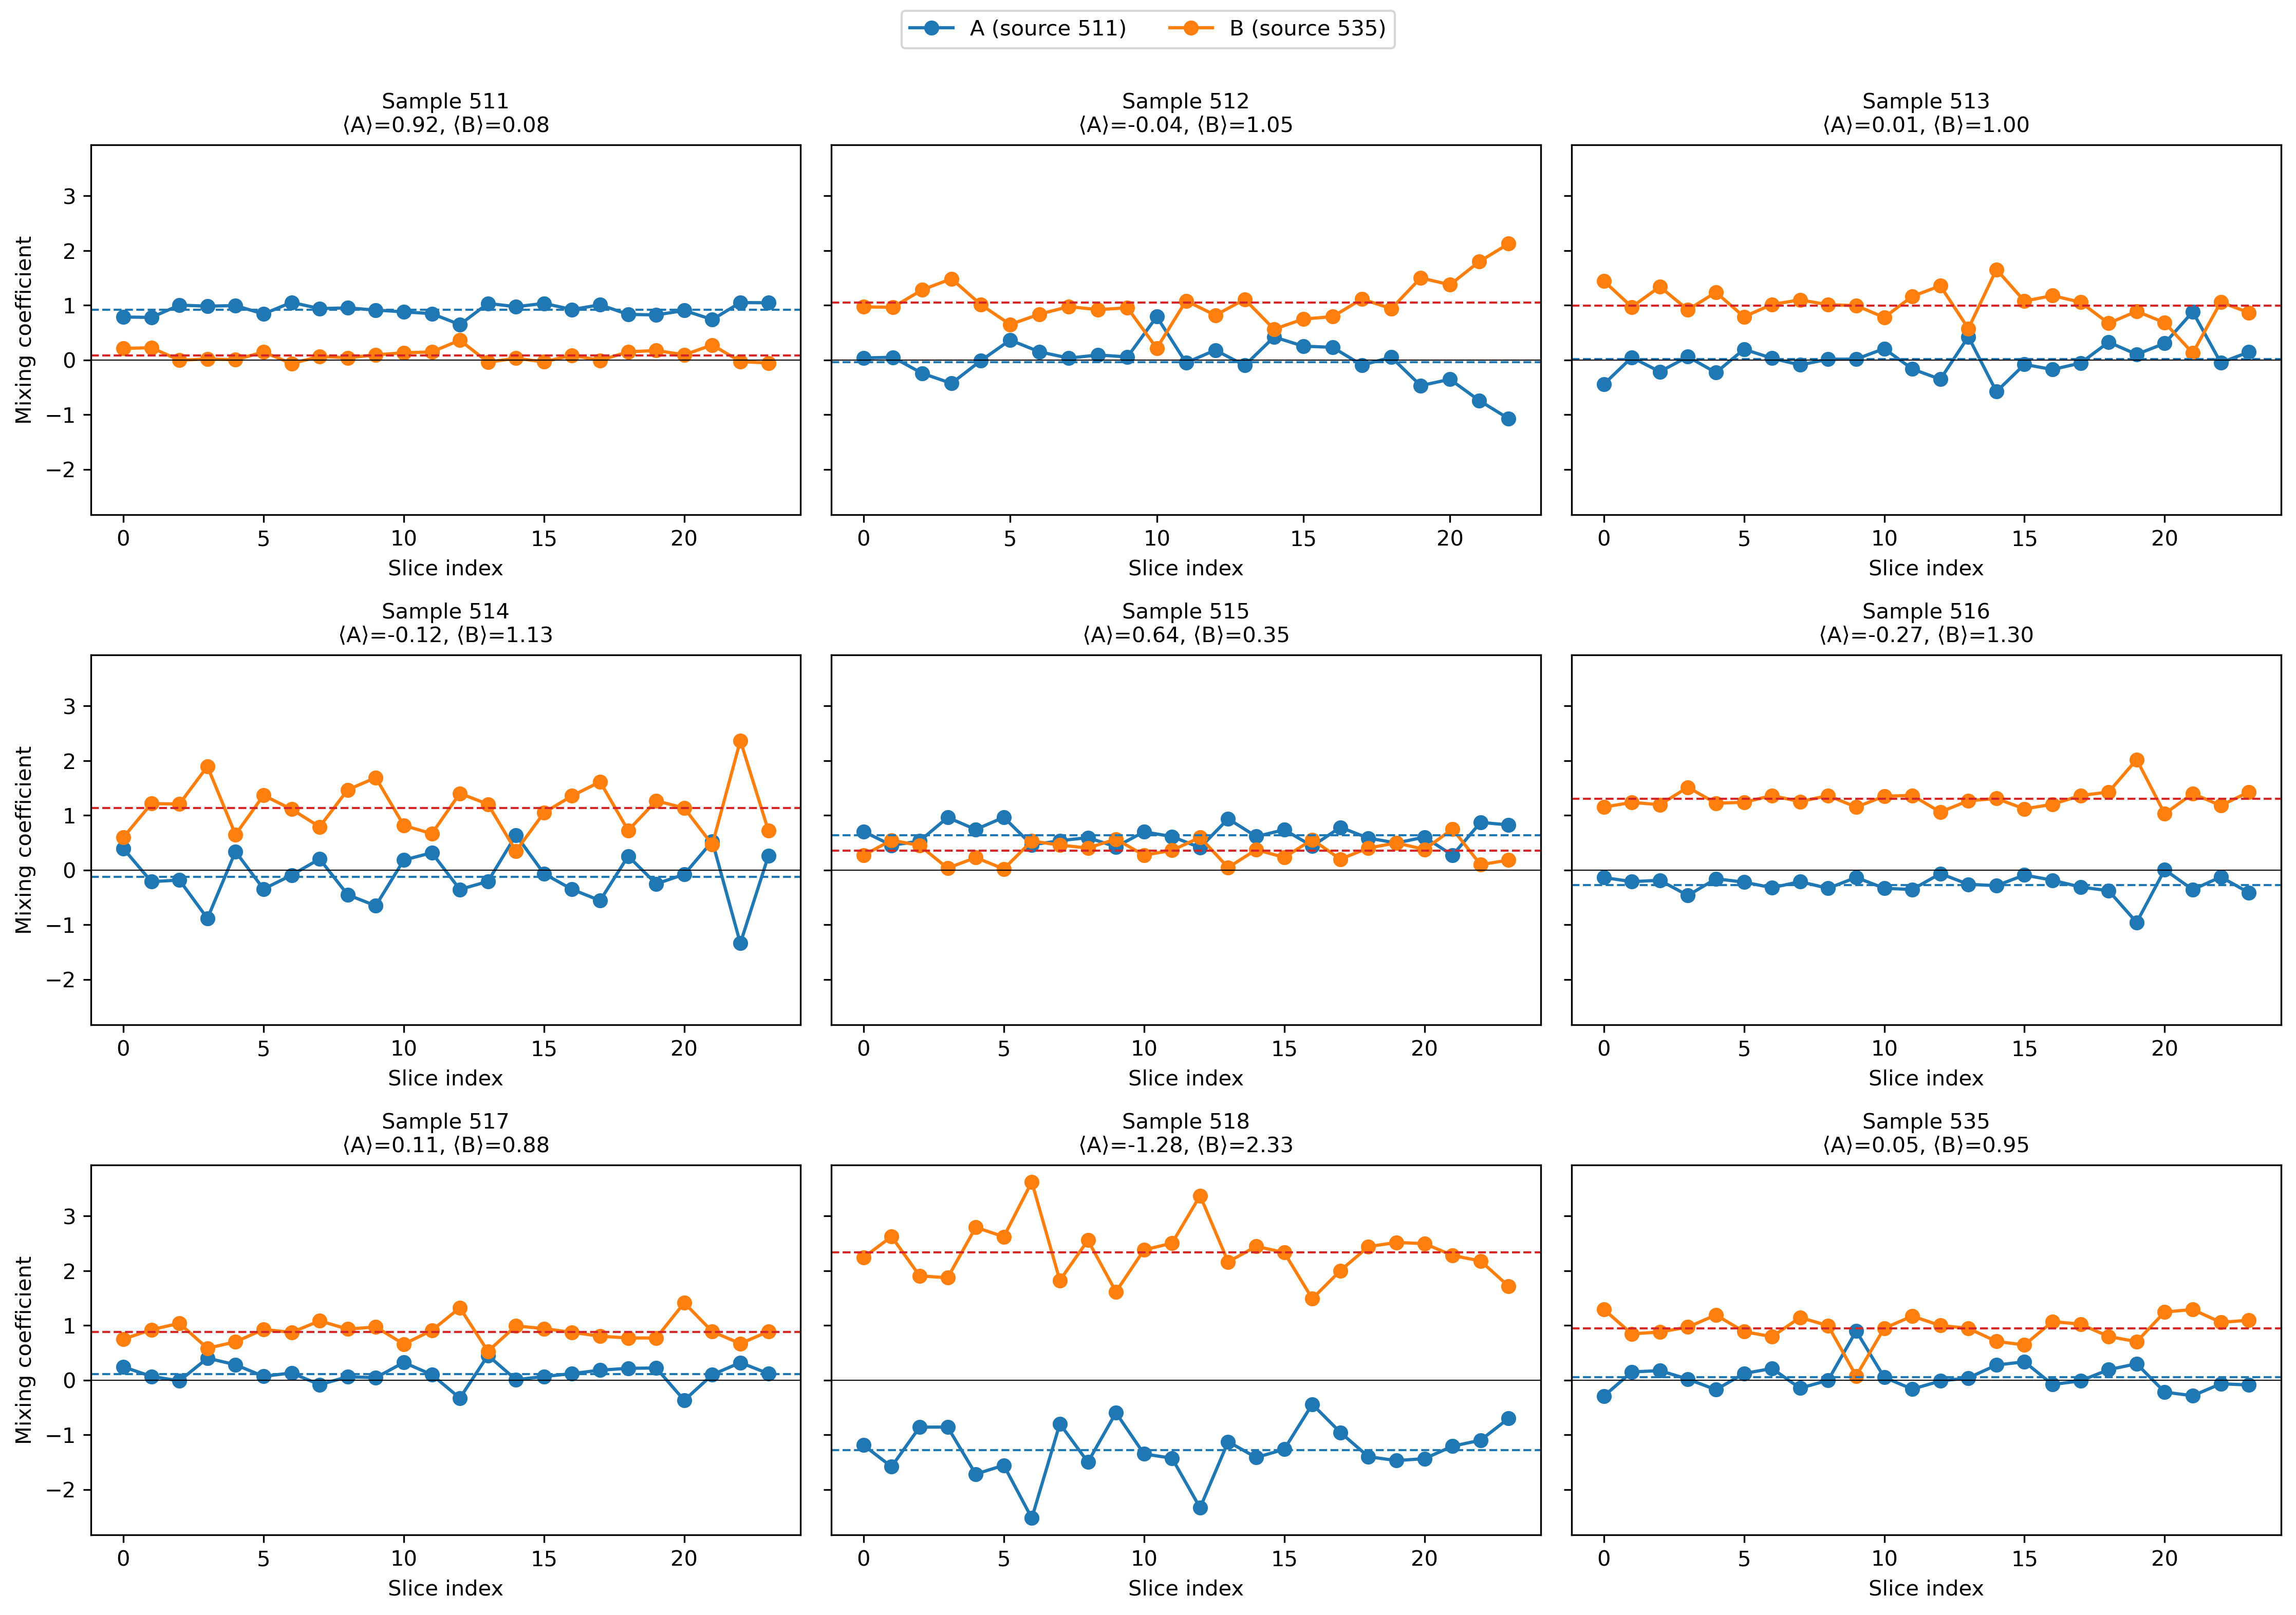

In [132]:
plot_AB_across_slices(results_df)


# 使用511和535的mean作为两个物源：
## 518 516 514 不属于 由 511和535组成的物源体系
## 512， 513， 517 物源主要受535控制
## 515 物源主要受 511控制
